## Making a QAOA Circuit

In [173]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [174]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [175]:

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_12 - 2*x_0*x_8 - 2*x_1*x_19 - 2*x_1*x_21 - 2*x_10*x_13
  - 2*x_10*x_16 - 2*x_10*x_23 - 2*x_11*x_14 - 2*x_11*x_23 - 2*x_11*x_24
  - 2*x_12*x_18 - 2*x_12*x_28 - 2*x_15*x_22 - 2*x_16*x_24 - 2*x_17*x_26
  - 2*x_17*x_27 - 2*x_2*x_15 - 2*x_2*x_17 - 2*x_2*x_26 - 2*x_20*x_21
  - 2*x_21*x_29 - 2*x_22*x_23 - 2*x_22*x_28 - 2*x_24*x_25 - 2*x_25*x_29
  - 2*x_26*x_29 - 2*x_3*x_14 - 2*x_3*x_20 - 2*x_3*x_27 - 2*x_4*x_15 - 2*x_4*x_25
  - 2*x_4*x_9 - 2*x_5*x_19 - 2*x_5*x_28 - 2*x_5*x_9 - 2*x_6*x_13 - 2*x_6*x_14
  - 2*x_6*x_18 - 2*x_7*x_13 - 2*x_7*x_16 - 2*x_7*x_19 - 2*x_8*x_20 - 2*x_8*x_27
  - 2*x_9*x_18 + 3*x_0 + 3*x_1 + 3*x_10 + 3*x_11 + 3*x_12 + 3*x_13 + 3*x_14
  + 3*x_15 + 3*x_16 + 3*x_17 + 3*x_18 + 3*x_19 + 3*x_2 + 3*x_20 + 3*x_21
  + 3*x_22 + 3*x_23 + 3*x_24 + 3*x_25 + 3*x_26 + 3*x_27 + 3*x_28 + 3*x_29
  + 3*x_3 + 3*x_4 + 3*x_5 + 3*x_6 + 3*x_7 + 3*x_8 + 3*x_9

Subject to
  No constraints

  Binary variables (30)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6

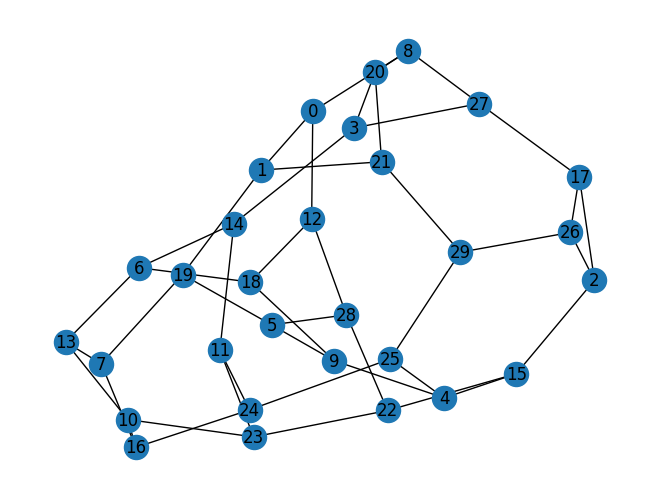

In [176]:
import networkx as nx

from qiskit_optimization.applications import Maxcut

seed = 12
num_nodes = 30



G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))

maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [177]:
# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

In [178]:
import time
pos = nx.spring_layout(G)


Best solution = [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0] cost = 41.0
elapsed time = 257605.59653401375 sec


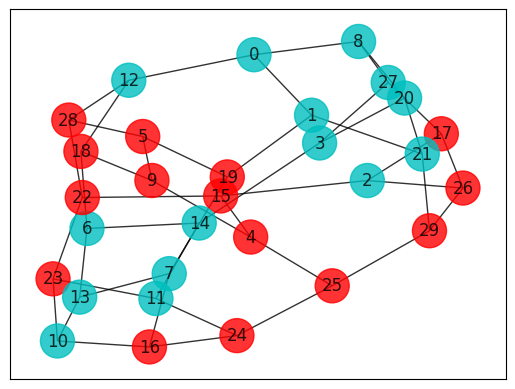

In [179]:
tic = time.time()
best_cost_brute = 0
for b in range(2**num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

In [180]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_12 - 2*x_0*x_8 - 2*x_1*x_19 - 2*x_1*x_21 - 2*x_10*x_13
  - 2*x_10*x_16 - 2*x_10*x_23 - 2*x_11*x_14 - 2*x_11*x_23 - 2*x_11*x_24
  - 2*x_12*x_18 - 2*x_12*x_28 - 2*x_15*x_22 - 2*x_16*x_24 - 2*x_17*x_26
  - 2*x_17*x_27 - 2*x_2*x_15 - 2*x_2*x_17 - 2*x_2*x_26 - 2*x_20*x_21
  - 2*x_21*x_29 - 2*x_22*x_23 - 2*x_22*x_28 - 2*x_24*x_25 - 2*x_25*x_29
  - 2*x_26*x_29 - 2*x_3*x_14 - 2*x_3*x_20 - 2*x_3*x_27 - 2*x_4*x_15 - 2*x_4*x_25
  - 2*x_4*x_9 - 2*x_5*x_19 - 2*x_5*x_28 - 2*x_5*x_9 - 2*x_6*x_13 - 2*x_6*x_14
  - 2*x_6*x_18 - 2*x_7*x_13 - 2*x_7*x_16 - 2*x_7*x_19 - 2*x_8*x_20 - 2*x_8*x_27
  - 2*x_9*x_18 + 3*x_0 + 3*x_1 + 3*x_10 + 3*x_11 + 3*x_12 + 3*x_13 + 3*x_14
  + 3*x_15 + 3*x_16 + 3*x_17 + 3*x_18 + 3*x_19 + 3*x_2 + 3*x_20 + 3*x_21
  + 3*x_22 + 3*x_23 + 3*x_24 + 3*x_25 + 3*x_26 + 3*x_27 + 3*x_28 + 3*x_29
  + 3*x_3 + 3*x_4 + 3*x_5 + 3*x_6 + 3*x_7 + 3*x_8 + 3*x_9

Subject to
  No constraints

  Binary variables (30)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6

### Make a Hamiltonian out of it

In [181]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -22.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIIZ', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIZII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIZIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIZIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIZIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIZIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIZIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIZIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIZIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIZIIIIIIIIII', 

In [182]:
# Problem to Hamiltonian operator
hamiltonian = qubitOp

In [183]:
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIIZ', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIZII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIZIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIZIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIZIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIZIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIZIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIZIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIZIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIZIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIZIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIZIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIZIIIIIIIIII',

### Make the QAOA from ansatz

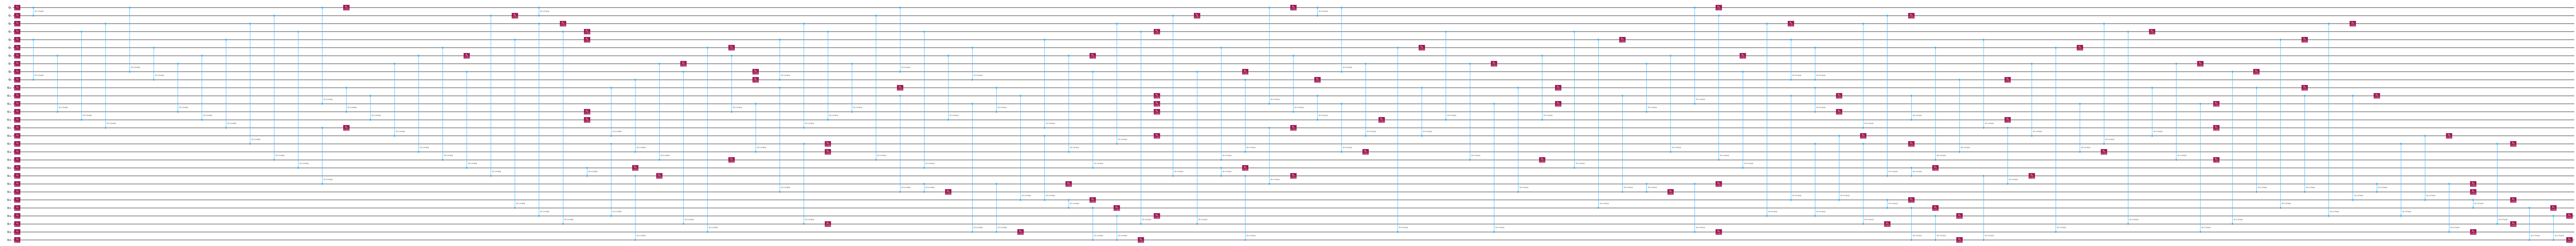

In [184]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=3)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [185]:
ansatz.num_qubits

30

In [186]:
ansatz.decompose().draw(output="mpl", style="iqp",fold=-1)

### Run the Uncut Circuit

In [187]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [188]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [189]:
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler,Estimator
#Aer.backends()
from qiskit_aer import AerSimulator
#backend = Aer.get_backend('qasm_simulator')
backend = AerSimulator(method='matrix_product_state')

In [190]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.46.0', 'qiskit-aer': '0.13.3', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.6.0', 'qiskit-machine-learning': None}

In [191]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.

options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 10000

session = Session(backend=backend)

estimator = Estimator()
sampler = Sampler()

In [192]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[1.08723962 2.37480788 4.82102142 4.41897211 2.13775737 1.11894182]


In [193]:
np.random.rand(ansatz.num_parameters)

array([0.2545724 , 0.77224169, 0.45392242, 0.29140752, 0.47459825,
       0.03862665])

In [194]:
x1 = np.random.uniform(- np.pi / 8.0, np.pi/ 8.0 ,ansatz.num_parameters)
print(x1)

[-0.06183974  0.17326721  0.23069803 -0.21195913 -0.30972853 -0.08517142]


In [195]:
print(x0)

[1.08723962 2.37480788 4.82102142 4.41897211 2.13775737 1.11894182]


In [196]:
tic = time.time()
res = minimize(cost_func, x1, args=(ansatz, hamiltonian, estimator), method="POWELL", options={"maxiter": 100})
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")


1. $30$ qubits ~ $116$ minutes

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.3505859375
       x: [ 6.918e-02  1.011e+00  1.155e+00 -8.381e-02  3.466e-03
            5.623e-01]
    nfev: 65
   maxcv: 0.0

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

In [ ]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
# Close the session since we are now done with it
session.close()

In [ ]:
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))

In [ ]:
#my_dict = samp_dist.binary_probabilities()
print(my_dict)

{'000111': 0.076171875, '010011': 0.0751953125, '110010': 0.064453125, '001101': 0.060546875, '111000': 0.05859375, '101100': 0.052734375, '111010': 0.0302734375, '101010': 0.0283203125, '110001': 0.025390625, '001110': 0.025390625, '101101': 0.0234375, '100011': 0.0234375, '010010': 0.0234375, '110011': 0.0224609375, '100101': 0.021484375, '110100': 0.0205078125, '000011': 0.0205078125, '101001': 0.0205078125, '010111': 0.0205078125, '001011': 0.0205078125, '110000': 0.01953125, '000101': 0.0185546875, '011010': 0.0185546875, '010101': 0.017578125, '111100': 0.017578125, '011100': 0.0166015625, '001111': 0.015625, '001100': 0.015625, '010110': 0.0146484375, '010100': 0.0107421875, '101000': 0.0107421875, '101111': 0.0087890625, '100001': 0.0087890625, '011111': 0.0078125, '000010': 0.0068359375, '011001': 0.0068359375, '000100': 0.005859375, '111011': 0.005859375, '101011': 0.005859375, '110111': 0.005859375, '001000': 0.005859375, '111110': 0.0048828125, '001010': 0.00390625, '010000

In [ ]:
print("Brute Force Solution: ", xbest_brute)
# first result from my_dict
print("QAOA Solution: ", list(my_dict.keys())[0])

Brute Force Solution:  [1, 1, 1, 0, 0, 0]
QAOA Solution:  000111


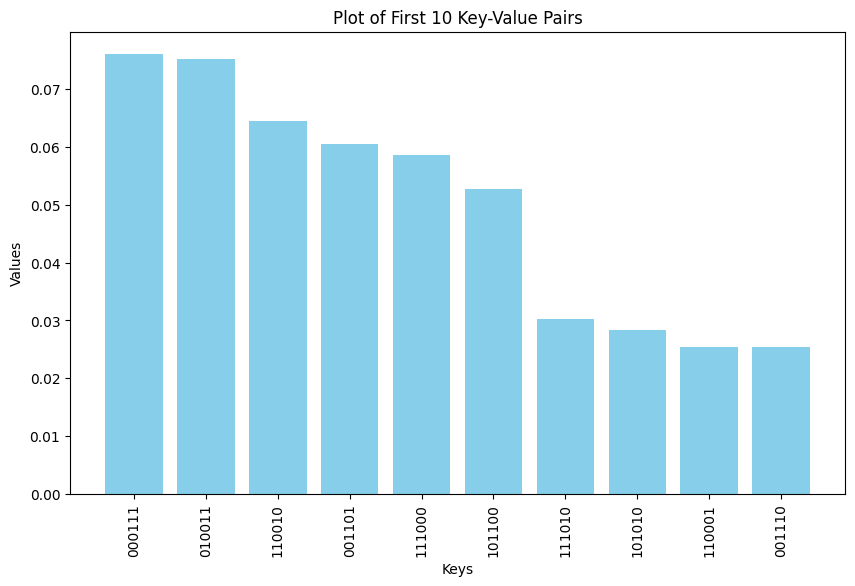

In [ ]:
# plot the histogram of my_dict, for only first 10 elements
# Extract first 10 key-value pairs
first_10_items = list(my_dict.items())[:10]
x_values = [item[0] for item in first_10_items]
y_values = [item[1] for item in first_10_items]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of First 10 Key-Value Pairs')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
Stop

NameError: name 'Stop' is not defined

# TIll Here

In [ ]:
print(samp_dist.binary_probabilities())

{'000010101100110001011111010001': 0.0009765625, '110101100100011011001100101010': 0.0009765625, '001110110011100010110010010101': 0.0009765625, '101010010011001100011101100100': 0.0009765625, '111010011011110100100000111000': 0.0009765625, '000100001111011111011100010100': 0.0009765625, '110111011001011011110010000001': 0.0009765625, '101011110001111001001100001100': 0.0009765625, '000101101110100001110010000101': 0.0009765625, '011100101011010110110001110000': 0.0009765625, '101101000001111100000101101101': 0.0009765625, '011010110011100000001100111100': 0.0009765625, '110110110001110001101010101100': 0.0009765625, '001110010010011100010010010111': 0.0009765625, '001101011001001010110100101111': 0.0009765625, '111001110011001111010101101000': 0.0009765625, '010101001110111101101010000011': 0.0009765625, '111100001001110111100000110100': 0.0009765625, '111001110101100110001000101001': 0.0009765625, '111010010110001111010101110010': 0.0009765625, '110110010001111111000100001000': 0.000

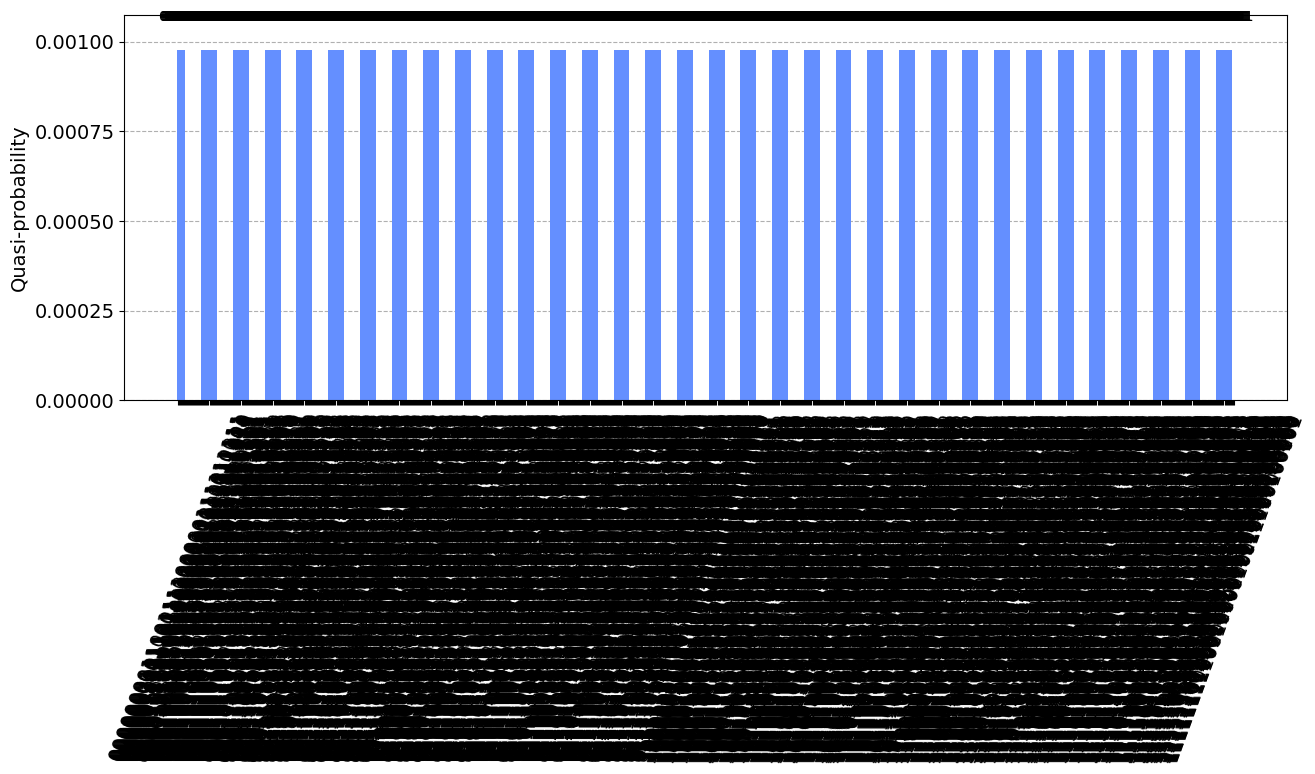

In [ ]:
plot_distribution(samp_dist.binary_probabilities(), figsize=(15, 5))

## Wire Cutting

In [ ]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.46.0', 'qiskit-aer': '0.13.3', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.6.0', 'qiskit-machine-learning': None}

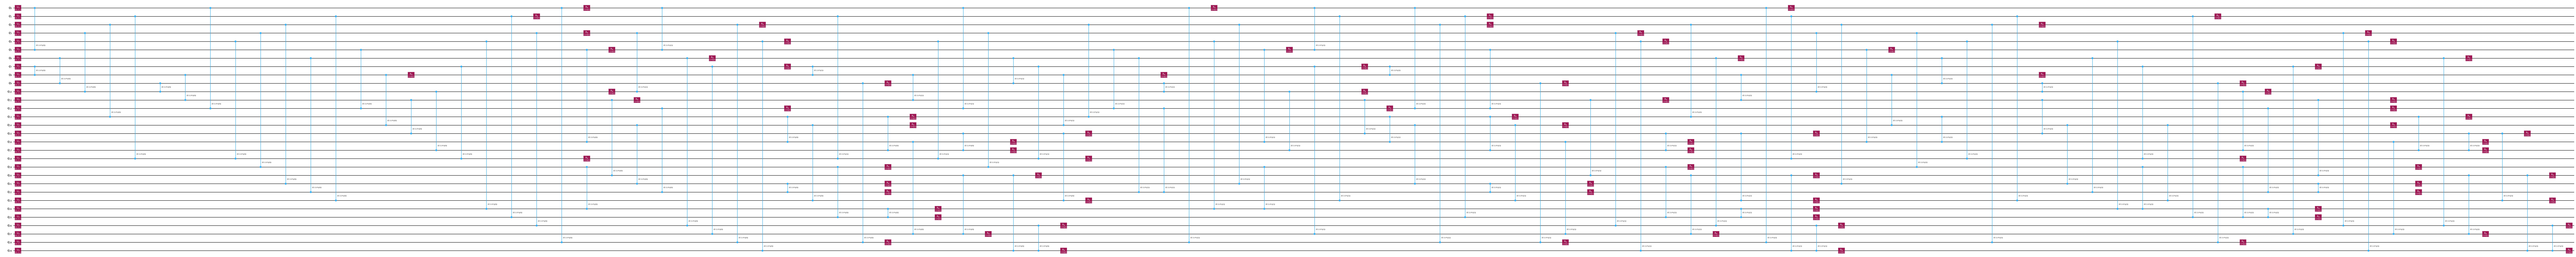

In [ ]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=3)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [ ]:
ansatz.num_qubits

30

### Transpile it, so that it's easy to cut

In [ ]:
from qiskit import transpile

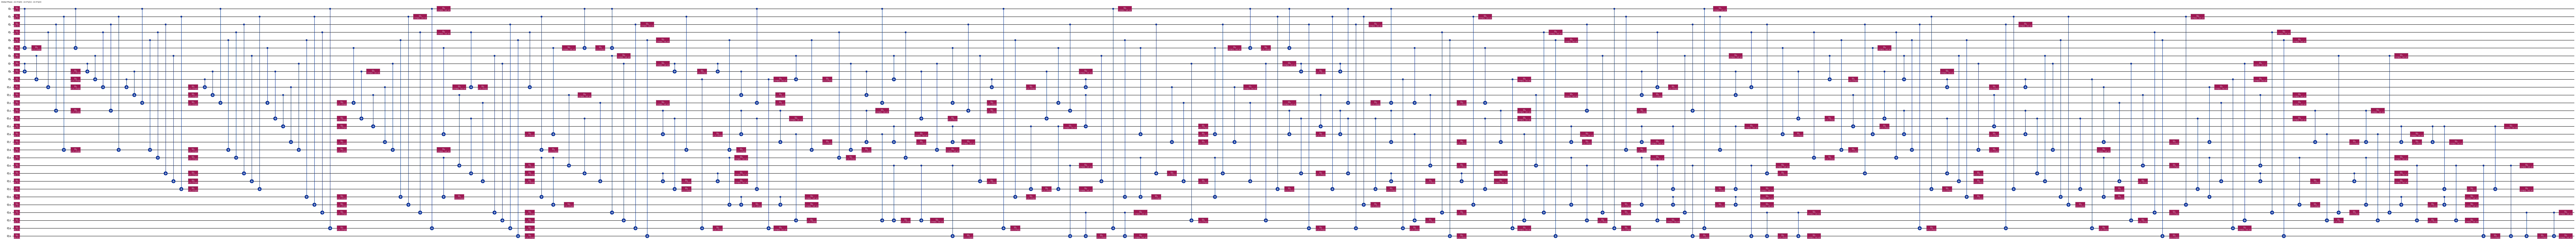

In [ ]:
circuit_basis = transpile(ansatz, basis_gates=['u3', 'cx'], optimization_level=3)
circuit_basis.draw(output="mpl", style="iqp",fold=-1)

### Invoke the Wire Cutting

```python
cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=8,
    max_cuts=400,
    num_subcircuits=[4],
)
```

In [ ]:
%%capture

from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=8,
    max_cuts=400,
    num_subcircuits=[4],
)

In [ ]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl",style='iqx', fold=-1, scale=0.6)

KeyError: 'subcircuits'

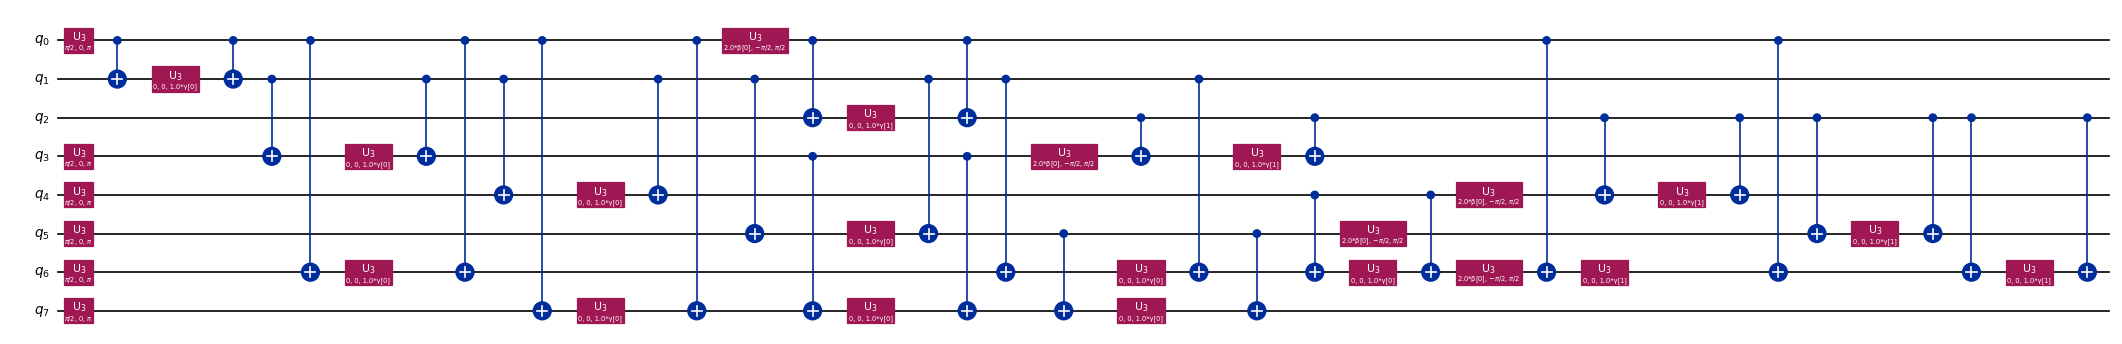

In [ ]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl",style='iqx', fold=-1, scale=0.6)

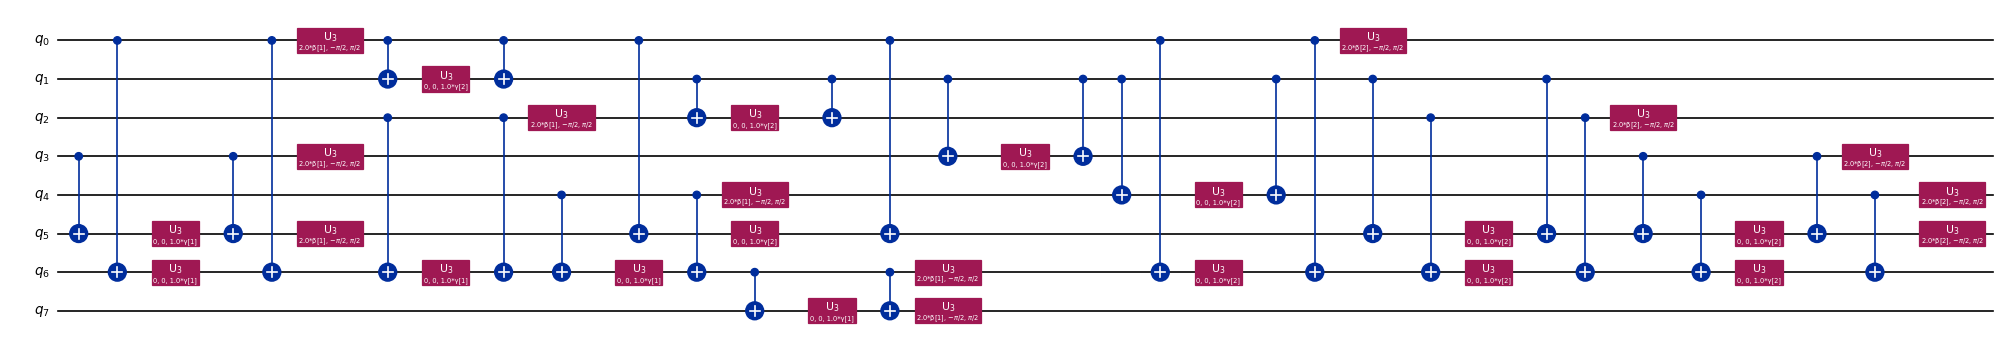

In [ ]:
# visualize the second subcircuit
cuts["subcircuits"][2].draw("mpl",style='iqx', fold=-1, scale=0.6)

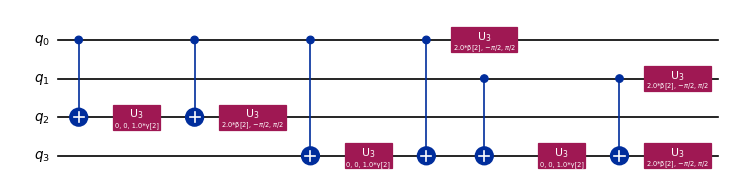

In [ ]:
# visualize the second subcircuit
cuts["subcircuits"][3].draw("mpl",style='iqx', fold=-1, scale=0.6)

## Evaluate the Subcircuits

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService  # noqa: F401

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime Service.
# service = QiskitRuntimeService()

### Configure the runtime Primitive

In [ ]:
from qiskit_ibm_runtime import Options

# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 4

## Evaluate on backends

In [ ]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

subcircuit_instance_probabilities = evaluate_subcircuits(cuts)

# Uncomment the following lines to instead use Qiskit Runtime Service as configured above.
# subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
#                                                          service_args=service.active_account(),
#                                                          backend_names=backend_names,
#                                                          options=options,
#                                                         )

## Inspecting the Subcircuit Results

In this case the original circuit was cut   times, you can get that information by:

In [ ]:
print("Total number of cuts: ",cuts['num_cuts'])
print("Number of subcircuits: ",len(cuts['subcircuits']))
# or can do
print("Number of subcircuits: ",len(subcircuit_instance_probabilities))

For these     wire cuts, there are $4^{} =  $ variants of the first subcircuit, and similary $4^{} = $ variants for the second, similarly for the third and same for fourth

In [ ]:
print(
    "Number of variants of 1st subcircuit: ", len(subcircuit_instance_probabilities[0])
)
print(
    "Number of variants of 2nd subcircuit: ", len(subcircuit_instance_probabilities[1])
)
print(
    "Number of variants of 3rd subcircuit: ", len(subcircuit_instance_probabilities[2])
)
print(
    "Number of variants of 4th subcircuit: ", len(subcircuit_instance_probabilities[3])
)